**Сравнение обученного и предобученного word2vec**

Данные: [корпус российский новостей](https://www.kaggle.com/datasets/vyhuholl/large-russian-news-dataset)

In [1]:
import pandas as pd
df = pd.read_csv('data\\russian_news.csv') # Корпус российских новостей

In [1]:
import string
def preprocess(doc):
    if type(doc) == str:
        doc = doc.lower()
        for p in string.punctuation + string.whitespace + 'http':
            doc = doc.replace(p, ' ')
        for p in ['«', '»', '\'', '\"']:
            doc = doc.replace(p, ' ')
        doc = doc.strip()
        doc = ' '.join([w for w in doc.split(' ') if w != ''])
    return doc

Предобработка текста

In [3]:
df['text'] = df['text'].apply(preprocess)

In [4]:
from gensim.utils import tokenize
class MySentences(object):  #Итератор для w2v, чтобы экономить оперативную память
    def __init__(self, df):
        self.df = df
    def __iter__(self):
        for doc in self.df.iterrows():
            if type(doc[1]['text'])!=str:
                continue
            sentences = doc[1]['text'].split('.')
            for sentence in sentences:
                tokens = list(tokenize(sentence))
                yield tokens

In [5]:
from gensim.models.word2vec import FAST_VERSION # Проверка подключен ли C компилятор к gensim
print(FAST_VERSION)

1


In [6]:
from gensim.models.callbacks import CallbackAny2Vec
class callback(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0
    def on_epoch_end(self, model):
        print('epoch: {}'.format(self.epoch))
        self.epoch += 1

In [7]:
from gensim.utils import effective_n_jobs
from gensim.models.word2vec import Word2Vec
sentences = MySentences(df)  # a memory-friendly iterator

Обучим word2vec с разными параметрами для дальнейшего сравнения

In [8]:
%%time
default_model = Word2Vec(sentences,vector_size=300, callbacks=[callback()], workers=effective_n_jobs(-1))
default_model.wv.save("data\\default.wordvectors")
del default_model

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
Wall time: 18min 54s


In [9]:
%%time
faster_model = Word2Vec(sentences,vector_size=300, callbacks=[callback()], workers=effective_n_jobs(-1),sample=1e-05,negative=3)
faster_model.wv.save("data\\faster.wordvectors")
del faster_model

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
Wall time: 18min 4s


In [10]:
%%time
wide_model = Word2Vec(sentences,vector_size=300, callbacks=[callback()], workers=effective_n_jobs(-1),sample=1e-05,negative=3, window=10)
wide_model.wv.save("data\\wide.wordvectors")
del wide_model

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
Wall time: 18min 2s


In [11]:
del sentences

Сохраним вектора w2v и загрузим их

In [33]:
from gensim.models import KeyedVectors
default_wv = KeyedVectors.load("data\\default.wordvectors", mmap='r')
faster_wv = KeyedVectors.load("data\\faster.wordvectors", mmap='r')
wide_wv = KeyedVectors.load("data\\wide.wordvectors", mmap='r')

In [2]:
from navec import Navec
navec = Navec.load('data\\navec_hudlit_v1_12B_500K_300d_100q.tar')
navec_wv = navec.as_gensim

Сравним w2v на стандартном выражении (король - мужчина + женщина = королева)

In [3]:
wvs = [default_wv, faster_wv, wide_wv, navec_wv]

NameError: name 'default_wv' is not defined

In [15]:
for wv in wvs:
    print(wv.most_similar(positive=['король', 'женщина'], negative=['мужчина']))

[('принцесса', 0.6401953101158142), ('королева', 0.6125698089599609), ('писательница', 0.5799705982208252), ('чета', 0.5662983655929565), ('актриса', 0.5656534433364868), ('кинозвезда', 0.5517865419387817), ('монахиня', 0.5493263006210327), ('певица', 0.5481252074241638), ('елизавета', 0.5354644060134888), ('художница', 0.5263227820396423)]
[('принцесса', 0.6633658409118652), ('императрица', 0.5775718092918396), ('камилла', 0.5710515975952148), ('величество', 0.566011369228363), ('елизавета', 0.5652220845222473), ('королева', 0.5593857765197754), ('gyanendra', 0.5573471784591675), ('королевой', 0.5564940571784973), ('короля', 0.5564342141151428), ('беатрикс', 0.5522288084030151)]
[('принцесса', 0.6999882459640503), ('королевой', 0.6144320368766785), ('королева', 0.6102306842803955), ('королевская', 0.6027457118034363), ('монарх', 0.5954500436782837), ('елизавета', 0.594951331615448), ('короля', 0.5935521721839905), ('беатрикс', 0.5893610715866089), ('камилла', 0.5873092412948608), ('мо

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:783: RuntimeWarning: invalid value encountered in true_divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


Ожидаемо лучше всего справился предобученный w2v, однако такого сравнения недостаточно, чтобы делать выводы о качестве эмбеддингов
Сравним векторные представления на задаче [анализа тональности](https://www.kaggle.com/competitions/sentiment-analysis-in-russian/data?select=train.json).

In [3]:
import pandas as pd
df = pd.read_json('data/RuSentiment.json')

In [4]:
df.head()

,text,id,sentiment
0,Досудебное расследование по факту покупки ЕНПФ...,1945,negative
1,Медики рассказали о состоянии пострадавшего му...,1957,negative
2,"Прошел почти год, как железнодорожным оператор...",1969,negative
3,По итогам 12 месяцев 2016 года на территории р...,1973,negative
4,Астана. 21 ноября. Kazakhstan Today - Агентств...,1975,negative


In [5]:
df['text'] = df['text'].apply(preprocess) # Предобработка

In [6]:
df.head()

,text,id,sentiment
0,досудебное расследование по факту покупки енпф...,1945,negative
1,медики рассказали о состоянии пострадавшего му...,1957,negative
2,прошел почти год как железнодорожным оператора...,1969,negative
3,по итогам 12 месяцев 2016 года на территории р...,1973,negative
4,астана 21 ноября kazak s an oday агентство рк ...,1975,negative


Определим dataset и dataloader для модели

In [7]:
import numpy as np

In [8]:
from torch.utils.data import Dataset, DataLoader
import torch
# Отображение названия класса в номер класса на выходе
num2ans = {
    'neutral': [1,0,0],
    'positive': [0,1,0],
    'negative':[0,0,1],
}

class sentiment_dataset(Dataset):
    # сам датасет
    def __init__(self, df, wv,max_length):
        self.df = df
        self.wv = wv
        self.max_length = max_length
        self.vocab = set(wv.index_to_key)
        self.length = len(self.df)
    # его размер
    def __len__(self):
        return self.length

        # получение примера по индексу
    def __getitem__(self, idx):
        text = self.df.iloc[idx, 0] # предобработанный текст
        label = self.df.iloc[idx, 2] # текст разметки
        label = num2ans[label] #номер класса разметки
        vectors = []
        n = 0
        for word in text.split():
            if word not in self.vocab:
                continue
            n+=1
            vectors.append(self.wv.key_to_index.get(word))
            if n > self.max_length:
                break
        text = torch.LongTensor(vectors) # тензор индексов номеров слов в словаре
        return text, label

In [9]:
from torch.nn.utils.rnn import pad_sequence
def collate_fn(batch):
    x = [e[0] for e in batch] # все индексы слов в словаре
    y = [e[1] for e in batch] # все индексы ответов
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    x = pad_sequence(x, batch_first = True).to(device)
    y = torch.tensor(y, dtype=torch.float).to(device)
    return x,y

In [10]:
from torch.utils.data import Subset
import multiprocessing

# сгенерирует случайные индесы теста
def subset_ind(dataset, ratio: float):
    return np.random.choice(len(dataset), size=int(ratio * len(dataset)), replace=False)

def get_train_test_loaders(df, wv,batch_size, max_doc_length, val_size = 0.2):
    dataset = sentiment_dataset(df, wv, max_doc_length)
    val_inds = subset_ind(dataset, val_size)
    # созаддим train датасет с индексов, не входящих в тестовые
    train_dataset = Subset(dataset, [i for i in range(len(dataset)) if i not in val_inds])
    # создадим test датасет из инедексов теста
    val_dataset = Subset(dataset, val_inds)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn,pin_memory=True, pin_memory_device=device, shuffle=True)
    test_dataloader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)
    return train_dataloader, test_dataloader

Определим LSTM нейронную сеть с эмбеддингами w2v

In [11]:
import torch
import torch.nn as nn

class lstm(nn.Module):
    def __init__(self, weights, dropout, hidden_size):
        super(lstm, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(weights)
        self.embedding.weight.requires_grad = False

        self.dropout = nn.Dropout(p = dropout) # регуляризация в процессе обучения
        self.lstm = nn.LSTM(input_size = self.embedding.embedding_dim, # размер эмбеддинга == инпута
                            hidden_size = hidden_size, # размер скрытого представления предложения (эмб.предложения)
                            num_layers = 1, # двуслойный LSTM
                            dropout = dropout, # регуляризация нужна из-за большого размера эмбеддинга
                            bidirectional = True) # каждый слой двунаправленный (т.е. 4 независимых LSTM-a)
        self.label = nn.Linear(hidden_size*2*1, 3) # полносвязный слой подключен к конкатинации 4х последних хидденов
    def forward(self, sentence):
        x = self.embedding(sentence)
        x = torch.transpose(x, dim0 = 1, dim1 = 0) # для подачи в лстм в верном формате
        out, (hidden, c) = self.lstm(x) # прогоняем через все ячейки LSTM
        x = self.dropout(torch.cat([c[i,:,:] for i in range(c.shape[0])], dim=1)) # конкартинируем и регуляризируем
        x = self.label(x) # отображаем для классификации
        return x

Процесс тренировки модели и вывода метрик:

In [28]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')

def train(epochs, model, loss_f, optimizer, train_i, val_i):
    step = 0

    losses = []
    val_losses = []

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print('Started training...')
    for epoch in range(epochs):
        for i, batch in enumerate(train_i):
            step += 1
            model.train()
            x, y = batch
            model.zero_grad()
            preds = model.forward(x)

            loss = loss_f(preds.to(device), y.to(device))
            losses.append(loss.cpu().data.numpy())
            loss.backward()
            optimizer.step()
            if step % 20 == 0:
                model.eval()
                vals = []
                f1s = []
                for batch in iter(val_i):
                    x, y = batch
                    preds = model.forward(x)
                    vals.append(np.average(loss_f(preds, y).cpu().data.numpy()))
                    f1s.append(f1_score(np.round(torch.sigmoid(preds).cpu().detach()), y.cpu().detach(), average='macro',  labels=np.unique(np.round(torch.sigmoid(preds).cpu().detach()))))
                print(f'epoch: {epoch+1}; iteration = {i+1}; loss: {np.average(losses[step-200:])}; val_loss: {np.average(vals)}; f1_score: {np.average(f1s)}')

        clear_output(True)
        model.eval()
        model.zero_grad()
        batch_val_losses = []
        for batch in iter(val_i):
            x, y = batch
            preds = model.forward(x)
            batch_val_losses.append(loss_f(preds, y).cpu().data.numpy())
        val_losses.append(np.average(batch_val_losses))

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle('Loss')

    axs[0].set_title('train cross-entropy loss')
    axs[1].set_title('test cross-entropy loss')

    axs[0].plot(losses)
    axs[0].plot(pd.Series(losses).rolling(200).mean().values)
    axs[1].plot(val_losses)
    f1s = []

    for batch in iter(val_i):
        x, y = batch
        preds = model.forward(x)
        f1s.append(f1_score(np.round(torch.sigmoid(preds).cpu().detach()), y.cpu().detach(), average='macro',  labels=np.unique(np.round(torch.sigmoid(preds).cpu().detach()))))
    axs[0].set(xlabel='step')
    axs[1].set(xlabel='epoch')
    print(f'final score: {np.average(f1s)}')
    plt.show()

In [29]:
from torch.optim import AdamW
def fit_lstm(wv, train_i, val_i, lr, weight_decay, hidden_size, dropout, epochs):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    weights = torch.FloatTensor(wv.vectors).to(device)

    model = lstm(weights, dropout=dropout, hidden_size=hidden_size).to(device)
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss = nn.CrossEntropyLoss()

    train(epochs, model, loss, optimizer, train_i, val_i)

    return model

Построим модели на наших w2v

In [30]:
df['text'].apply(lambda x: len(x.split())).describe()

count     8263.000000
mean       523.802977
std       1189.388937
min          4.000000
25%        169.000000
50%        278.000000
75%        492.000000
max      47985.000000
Name: text, dtype: float64

Будем обрезать предложения т.к. подавляющее большинство документов гораздо короче, чем максимальный

In [31]:
epochs = 20
lr= 1e-4
weight_decay = 1e-4
hidden_size = 128
dropout = 0.8
batch_size = 200
max_doc_length = 500 # Все документы длинее 500 слов будут обрезаны

final score: 0.6748344591146617


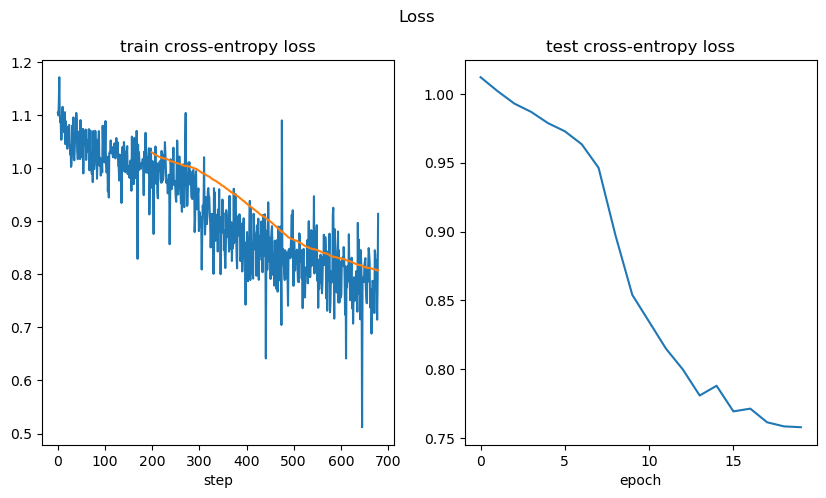

Wall time: 2min 20s


In [32]:
%%time

train_loader, test_loader = get_train_test_loaders(df, navec_wv,batch_size, max_doc_length)
model = fit_lstm(navec_wv, train_loader, test_loader, lr, weight_decay, hidden_size, dropout, epochs)
del model, train_loader, test_loader

final score: 0.6386239791356155


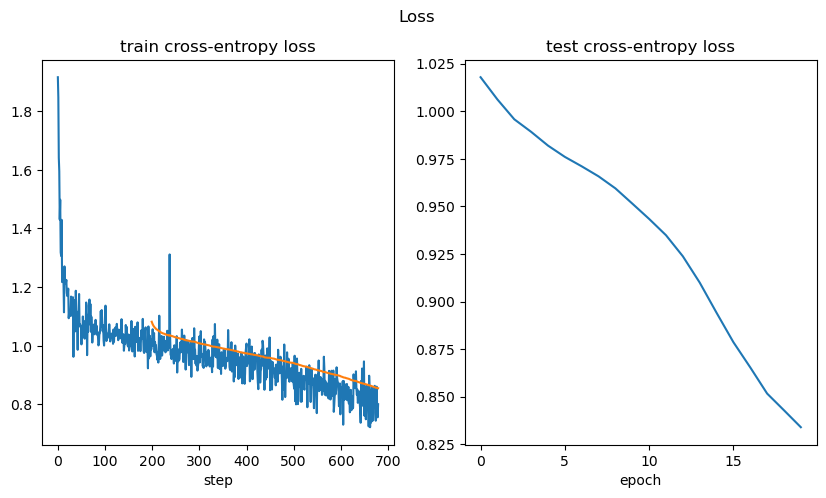

Wall time: 2min 19s


In [34]:
%%time
train_loader, test_loader = get_train_test_loaders(df, default_wv, batch_size, max_doc_length)
model = fit_lstm(default_wv, train_loader, test_loader, lr, weight_decay, hidden_size, dropout, epochs)
del model, train_loader, test_loader

final score: 0.659036623171379


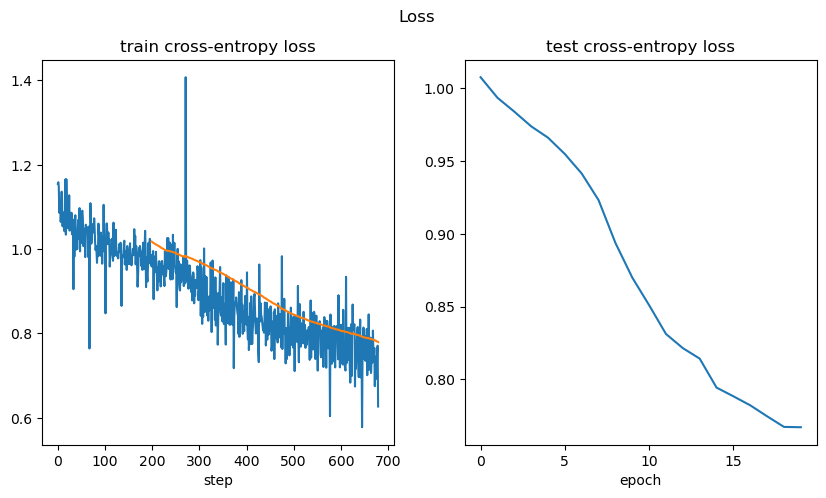

Wall time: 2min 18s


In [35]:
%%time
train_loader, test_loader = get_train_test_loaders(df, faster_wv,batch_size, max_doc_length)
model = fit_lstm(faster_wv, train_loader, test_loader, lr, weight_decay, hidden_size, dropout, epochs)
del model, train_loader, test_loader

final score: 0.6344323978876231


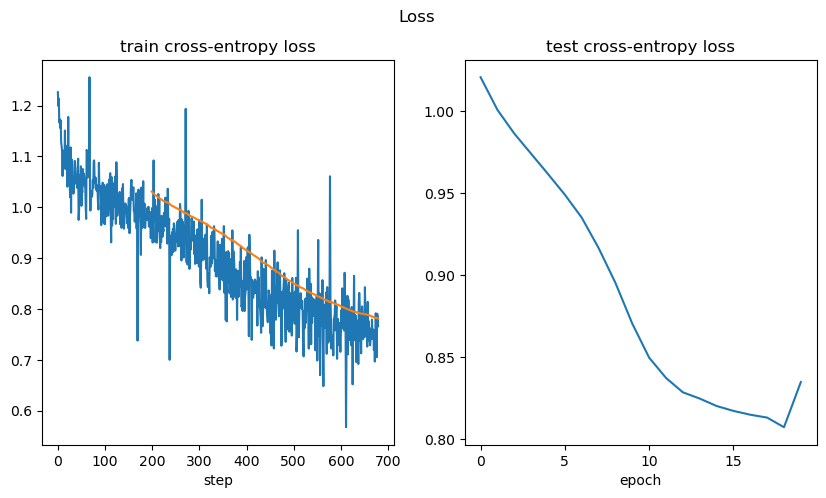

Wall time: 2min 19s


In [36]:
%%time
train_loader, test_loader = get_train_test_loaders(df, wide_wv,batch_size, max_doc_length)
model = fit_lstm(wide_wv, train_loader, test_loader, lr, weight_decay, hidden_size, dropout, epochs)
del model, train_loader, test_loader

Наилучшие результаты удалось получить при использовании предобученного w2v
Модель, параметры которой ускоряли процесс тренировки, справилась лучше обычной
Модель с широким окном показала результаты хуже стандартных настроек.